# Lecture 17: The sledgehammer approach to the latitude EBM

The goal of this script is to compute steady-state solutions for the latitude EBM introduced in lectures using the 'sledgehammer' approach of Newton's method. We will find that, although this works, it is highly dependent on starting with the correct initial guess. 

We seek the steady-state solutions via 
$$
T* = \Phi(T*) = \frac{Q s(y)[1 - a(T*)] - A + k\bar{T^*}}{B + k}
$$

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import sys, time

Set the parameters according to those given in lectures

In [83]:
A = 202 # outgoing radiation
B = 1.9 # outgoing radiation
k = 1.6*B # transport parameter
s = lambda y: 1 - 0.482*(3*y**2 - 1)/2 # solar weighting
aw = 0.32 # water albedo
ai = 0.62 # ice albedo
Tc = -10.0 # critical temperature for ice formation
Q = 342.0 # solar constant (1380 W/m^2 divided by 4)

def Tbar(y, T):
    # Riemann sum approximation of the integral T(y) over y    
    I = 0
    I = np.trapz(T, y)
    # for i in range(0, np.size(y)-1):
    #     dy = y[i+1] - y[i]
    #     I = I + T[i]*dy
    #     # print(i, yi, T[i])
    #     # I = I + 0.5*(T[i] + T[i+1])*dy
    return I

def afunc(y, ys):     
    a = 0*y    
    a = (aw + ai)/2 + (ai-aw)/2*np.tanh(100*(y-ys))
    return a

def myPhi(T, y, ys):
    Tb = Tbar(y, T)
    Phi = (k*Tb + Q*s(y)*(1 - afunc(y, ys)) - A)/(B+k)
    return Phi

def myF(X, y):
    N = len(y)
    T =  X[0:N]
    ys = X[N]
    Phi = myPhi(T, y, ys)    
    F = np.zeros(N+1)
    F[0:N] = T - Phi
    F[N] = np.interp(ys, y, T) - Tc
    print(F)
    time.sleep(10)
    return F


# Initialise the mesh with N points
N = 10
y = np.linspace(0, 1, N)

# Iterative scheme
# Form an initial guess 
# Try this one for the fake solution
Tequator = 20; Tpole = -12;
T = Tequator + (Tpole - Tequator)*y
guess = np.append(T, 0.95)

# Run the solver
fwd = lambda X: myF(X, y)
sol, info, ier, msg = fsolve(fwd, guess, full_output=1)
print(msg)
T = sol[0:N]
ys = sol[N]
print(ys)
print(np.interp(ys,y,T))
plt.plot(y, sol[0:N])
plt.plot([ys, ys], [-20, 20])
plt.grid(1)
# # Plot the output
# solT = sol.x;
# fig = plt.figure(figsize=(6,4))
# plt.plot(y, solT, '-o')
# plt.xlabel('y'); plt.ylabel('T')
# plt.title("Mean temperature = %1.3f" % Tbar(y, solT));

[ 6.68825911e-03 -3.12866217e+00 -5.42360234e+00 -6.87813225e+00
 -7.49225191e+00 -7.26596131e+00 -6.19926046e+00 -4.29214935e+00
 -1.54455954e+00  1.28012768e+01 -4.00000000e-01]
[ 6.68825911e-03 -3.12866217e+00 -5.42360234e+00 -6.87813225e+00
 -7.49225191e+00 -7.26596131e+00 -6.19926046e+00 -4.29214935e+00
 -1.54455954e+00  1.28012768e+01 -4.00000000e-01]


KeyboardInterrupt: 

In [76]:
info

{'nfev': 735,
 'fjac': array([[-0.99951921,  0.00311619,  0.00311619, ...,  0.00311619,
          0.00311619,  0.        ],
        [-0.00119716, -0.99807345,  0.00626618, ...,  0.00626617,
          0.00626617,  0.        ],
        [-0.00120761, -0.00241524, -0.9980567 , ...,  0.00632092,
          0.00632091,  0.        ],
        ...,
        [-0.00725888, -0.01451776, -0.01451778, ..., -0.98860643,
          0.03799405, -0.03054142],
        [-0.00769923, -0.01539849, -0.01539849, ..., -0.01539846,
         -0.98805191, -0.02756115],
        [ 0.00606115,  0.01212234,  0.01212234, ...,  0.01212232,
          0.00606117, -0.75007619]]),
 'r': array([-9.97371543e-01,  7.41152107e-03,  7.41154329e-03, ...,
        -9.80352671e-01,  1.92188686e+01, -1.07693312e+00]),
 'qtf': array([0.000234  , 0.00026632, 0.00026865, 0.00027102, 0.00027343,
        0.00027588, 0.00027837, 0.00028092, 0.00028351, 0.00028614,
        0.00028883, 0.00029157, 0.00029436, 0.00029721, 0.00030011,
        0.

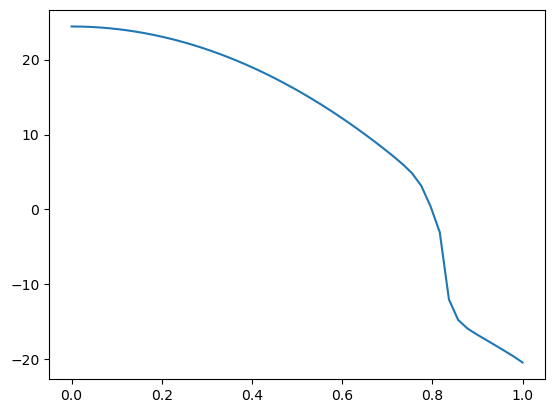

In [2]:
# 2022-23 delivery: ignore the below
# # Iterative scheme
# # Form an initial guess 
# # Try this one for the fake solution
# # Tequator = 20; Tpole = -20;
# # Try this one for the true solution
# Tequator = 20; Tpole = -12;
# T = Tequator + (Tpole - Tequator)*y
# # T = 0*y - 9.5
# # T = 0*y - 30
# # T = 0*y + 30
# plt.figure()
# for i in range(0,50):
#     T = myPhi(T,y)
#     Tb = Tbar(y,T)
#     plt.plot(i, Tb, 'o')